# Problem 1

Загрузитя `.wav` файл, изобразите сигнал и прослушайте его тут.

In [1]:
import urllib.request
import os
from scipy.io import wavfile 
from matplotlib import pyplot as plt
import IPython.display as ipd
import pathlib

def downlod_wav():
  url = 'https://drive.google.com/uc?id\u003d1jybDphsdn3tma5sqmMjgFM8nrG6Om6dn\u0026export\u003ddownload'
  filename = os.path.join(pathlib.Path().absolute(), 'file.wav')
  urllib.request.urlretrieve(url, filename)

  Fs, data = wavfile.read(filename)
  return Fs, data

def read_wav(name):
  filename = os.path.join(pathlib.Path().absolute(), name)
  Fs, data = wavfile.read(filename)
  return Fs, data

def write_wav(Fs, data, name):
  filename = os.path.join(pathlib.Path().absolute(), name)
  wavfile.write(filename, Fs, data)

def read_array(name):
  filename = os.path.join(pathlib.Path().absolute(), name)
  A = np.loadtxt(filename)
  #print('load ', name, ': ', A)
  return A

def write_array(A, name):
  filename = os.path.join(pathlib.Path().absolute(), name)
  np.savetxt(filename, np.array(A))
  #print('save ', name, ': ', A)


def display_wav(data):
  plt.figure(figsize=(16, 4))
  plt.plot(data)
  plt.xlim([0, data.shape[0]])
  plt.xlabel('Time (samples)')
  plt.ylabel('Amplitude')
  plt.show()  

def play_wav(Fs, data):
  ipd.display(ipd.Audio(data=data, rate=Fs))

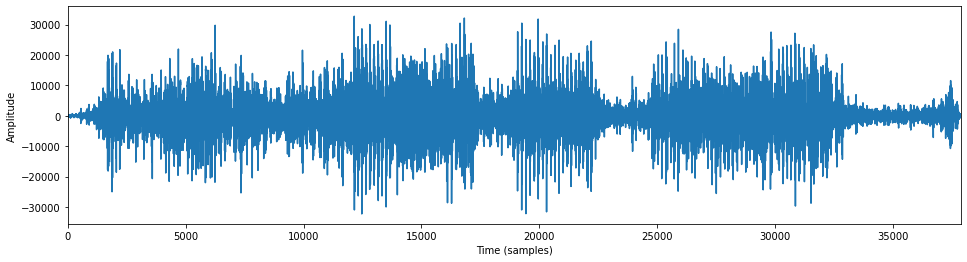

In [2]:
Fs, data = downlod_wav()
write_wav(Fs, data, 'Original.wav')
display_wav(data)
play_wav(Fs, data)

Возьмите такую часть сигнала, чтобы матрица $N \times N$ и операции над ней не вызывали свапа. Ответ обосновать, расчитать около максимальное такое $N$

Сигнал нужно теперь свернуть со следующей матрицей:
$$y_{convolved} = T x$$
$$T_{ij} = \sqrt{\frac{\alpha}{\pi}}e^{-\alpha (i-j)^2}, \quad i,j=1,\dots,N$$

- Реализуйте функцию, которая создает такую матрицу, не используя списки и циклы, как называются такие матрицы ?
- Реализуйте функцию, которая возвращает свертку
- Изобразите для $\alpha = 0.2,~\alpha=0.01$ на одном графике исходный сигнал и свернутый (два графика соответственно), изобразите только часть данных для репрезентативности.
- Воспроизведите свернутый сигнал в виде аудио

In [3]:
import math
import jax.numpy as np
import scipy as sp

def generate_conv_matrix(N, alfa):

  T = []
  values = np.zeros(N)
  pi = math.pi
  s = math.sqrt(alfa/pi)
  for i in range(N):
    values[i] = s * math.exp(-alfa*(i)**2)

  tt = values.copy()
  for i in range(N):
    T.append(tt)
    if i < (N-1):
      tt = [values[i+1], *tt[:-1]]

  return np.array(T)

In [4]:
import jax.numpy as np

def mult(T, data):
  return np.dot(T, data)

Исходный сигнал


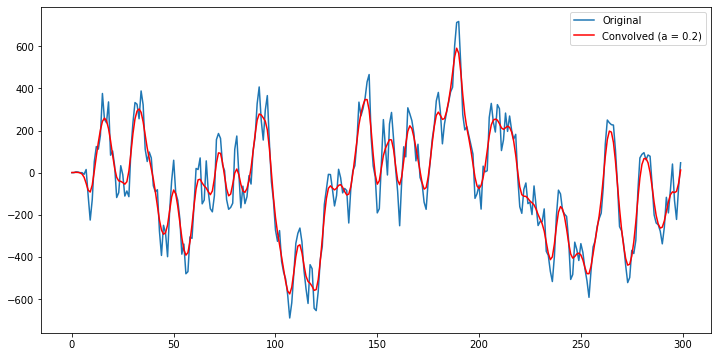

Свернутый сигнал с альфа = 0.2


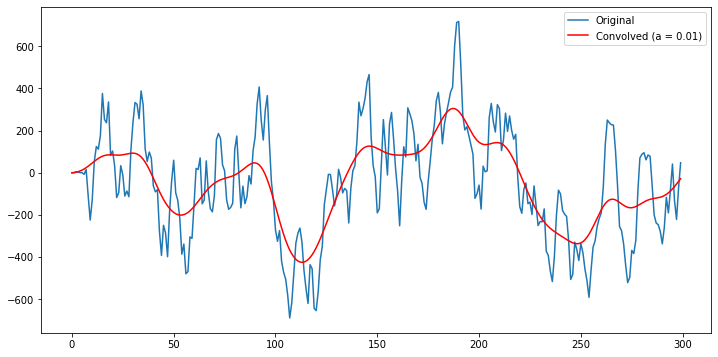

Свернутый сигнал с альфа = 0.01


In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

N = 10000    #Размер матрицы и куска сигнала для свертки
M = 300      #Кусок сигнала для отображения на графике
Fs, data = read_wav('Original.wav')
data = data[:N]

print('Исходный сигнал')
#display_wav(data)
play_wav(Fs, data)

T = generate_conv_matrix(N, 0.2)
y = mult(T, data)
write_wav(Fs, y, 'Convolved02.wav')

plt.figure(figsize=(12, 6))
plt.plot(range(M), data[:M], label='Original')
plt.plot(range(M), y[:M], 'r', label='Convolved (a = 0.2)')
plt.legend()
plt.show()

print('Свернутый сигнал с альфа = 0.2')
play_wav(Fs, y)

T = []
y =[]
T = generate_conv_matrix(N, 0.01)
y = mult(T, data)
write_wav(Fs, y, 'Convolved001.wav')

plt.figure(figsize=(12, 6))
plt.plot(range(M), data[:M], label='Original')
plt.plot(range(M), y[:M], 'r', label='Convolved (a = 0.01)')
plt.legend()
plt.show()

print('Свернутый сигнал с альфа = 0.01')
play_wav(Fs, y)



А теперь давайте попробуем его восстановить. Выражение для получения свернутого сигнала есть ни что иное как СЛАУ с неизвестным исходным сигналом. Давайте решим это уравнение итерационным методом.

- Реализуйте метод Ричарсона с оптимальным шагом
- Реализуйте метод Ричарсона с переменным шагом, который на каждой итерации минимизирует норму невязки, выражение для оптимального шага получить аналитически
- Реализуйте метод Чебышева (с перестановкой корней задание со звездочкой)
- Для каждого $\alpha$ постройте график относительной погрешности реализованных методов.
- Добавьте небольшой случайный шум к свернутому сигналу ($10^{-3}\max(x)$), постройте графики сходимости, обоснуйте результаты на них.



Реализуем метод Ричардсона с оптимальным шагом.

In [6]:
import scipy.sparse.linalg as spla
from scipy import sparse

def calc_opt_tau(T):
  T = sparse.csr_matrix(T)
  ev1, vec = spla.eigsh(T, k=2, which='LA')
  #ev2, vec = spla.eigsh(T, k=2, which='SA')
  lam_max = ev1[0]
  lam_min = ev1[1]
  return 2.0/(lam_max + lam_min)

def Richardson_sol(A, b, niters, tau, original):
  n = len(b)
  x = np.zeros(n)
  error = []
  nb = np.linalg.norm(original)
  for i in range(niters):
    rr = np.dot(A, x) - b
    x = x - tau * rr
    nr = np.linalg.norm(x - original)
    error.append(nr / nb)

  return x, error



Посчитаем оптимальное $\tau$ для алгоритма Ричардсона. Получили, что $\tau_{0,2} = 1.0000003083037587$, $\tau_{0,01} = 1.0000061583326656$.

In [7]:
def tau():
  Fs, data = read_wav('Convolved02.wav')
  N = len(data)
  T = generate_conv_matrix(N, 0.2)
  tau = calc_opt_tau(T)
  print(tau)

  Fs, data = read_wav('Convolved001.wav')
  N = len(data)
  T = generate_conv_matrix(N, 0.01)
  tau = calc_opt_tau(T)
  print(tau)

#tau() 

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def output_graph(orig, data, res_data, l):

  M = 100     #Количество точек для отображения на графике
  
  plt.figure(figsize=(12, 6))
  plt.plot(range(M), orig[:M], 'k', label='Original')
  plt.plot(range(M), data[:M], 'r', label=l)
  plt.plot(range(M), res_data[:M], label='Restored')
  plt.legend()
  plt.show()
  #print('Восстановленный сигнал')
  #play_wav(Fs, res_data)


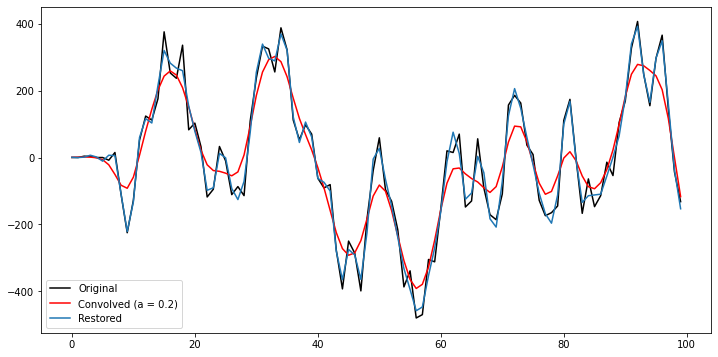

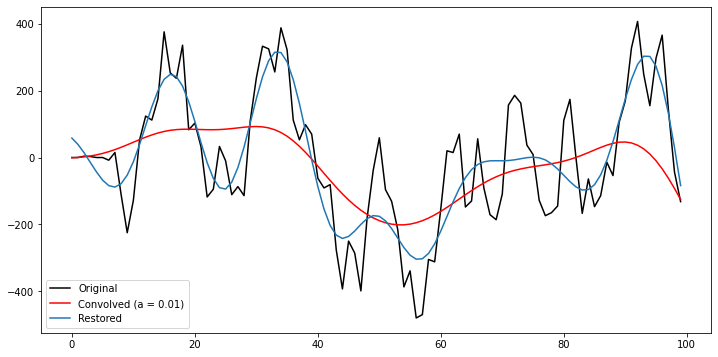

In [9]:
import numpy as np
import matplotlib.pyplot as plt

Maxit = 100 #Максимальное количество итераций
Fs, orig = read_wav('Original.wav')
Fs, data = read_wav('Convolved02.wav')
N = len(data)
orig = orig[:N]
T = generate_conv_matrix(N, 0.2)
res_data, error = Richardson_sol(T, data, Maxit, 1.0000003083037587, orig)
output_graph(orig, data, res_data, 'Convolved (a = 0.2)')
write_array(error, 'Richardson02.err')

Fs, data = read_wav('Convolved001.wav')
N = len(data)
T = generate_conv_matrix(N, 0.01)
res_data, err = Richardson_sol(T, data, Maxit, 1.0000061583326656, orig)
output_graph(orig, data, res_data, 'Convolved (a = 0.01)')
write_array(error, 'Richardson001.err')

Реализуем метод Чебышева. Из-за того, что мы пеерсчитываем $\tau$ на каждой итераии, что происходит довольно долго, мы уменьшили интервал свертки до 1000, чтобы показать, как работает алгоритм и дождаться результата его работы.

In [10]:
import math
def Cheb_sol(A, b, niters, orig):
  n = len(b)
  x = np.zeros(n)
  T = sparse.csr_matrix(A)
  ev1, vec = spla.eigsh(T, k=2, which='LA')
  lam_max = ev1[0]
  lam_min = ev1[1]
  error = []
  nb = np.linalg.norm(orig)
  for i in range(niters):
    xx = math.cos(math.pi * (2*i+1) / 2*n)
    tau = 2.0/(lam_max + lam_min - (lam_max - lam_min)*xx)
    rr = np.dot(A, x) - b
    x = x - tau * rr
    nr = np.linalg.norm(x - orig)
    error.append(nr / nb)

  return x, error

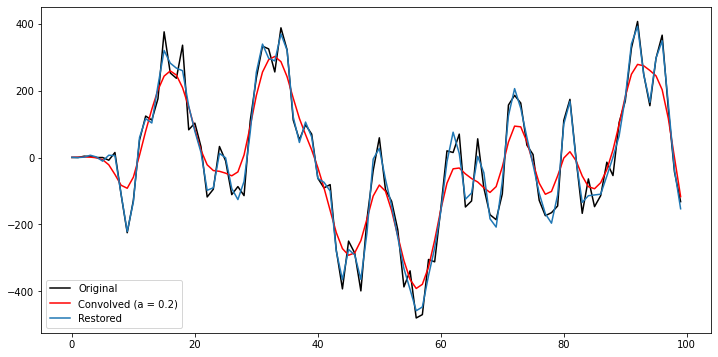

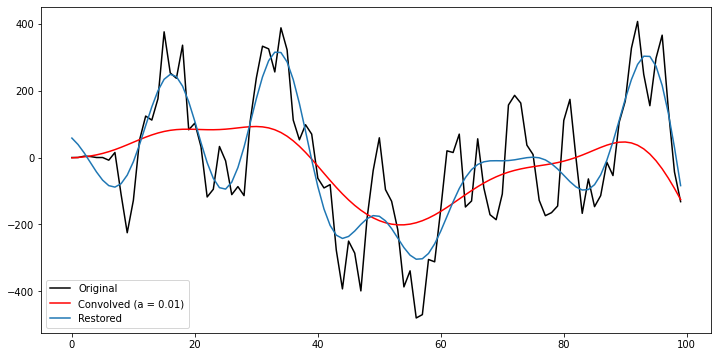

In [11]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000
Maxit = 100 #Максимальное количество итераций
Fs, orig = read_wav('Original.wav')
orig = orig[:N]
Fs, data = read_wav('Convolved02.wav')
data = data[:N]
T = generate_conv_matrix(N, 0.2)
res_data, error = Cheb_sol(T, data, Maxit, orig)
output_graph(orig, data, res_data, 'Convolved (a = 0.2)')
write_array(error, 'Cheb02.err')

Fs, data = read_wav('Convolved001.wav')
data = data[:N]
T = generate_conv_matrix(N, 0.01)
res_data, error = Cheb_sol(T, data, Maxit, orig)
output_graph(orig, data, res_data, 'Convolved (a = 0.01)')
write_array(error, 'Cheb001.err')

А теперь нарисуем график относительной ошибки методов в зависимости от числа итераций.

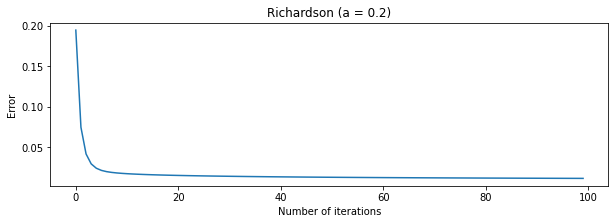

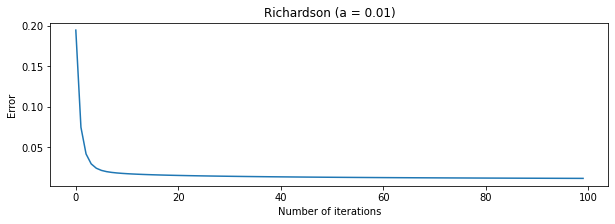

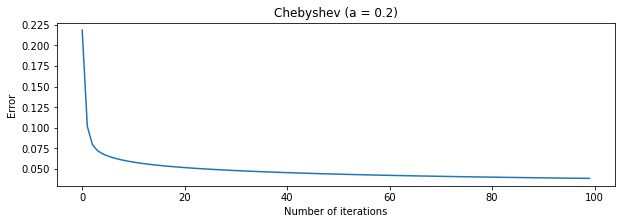

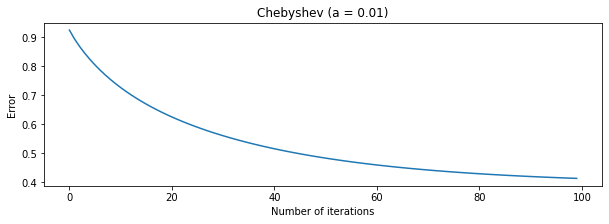

In [12]:
import numpy as np
import matplotlib.pyplot as plt

R02 = read_array('Richardson02.err')
R001 = read_array('Richardson001.err')
C02 = read_array('Cheb02.err')
C001 = read_array('Cheb001.err')

xx = range(len(R02))

plt.figure(figsize=(10, 3))
plt.plot(xx, R02)
plt.title('Richardson (a = 0.2)')
plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(xx, R001)
plt.title('Richardson (a = 0.01)')
plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(xx, C02)
plt.title('Chebyshev (a = 0.2)')
plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(xx, C001)
plt.title('Chebyshev (a = 0.01)')
plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.show()



Теперь добавим в свернутый сигнал шум.

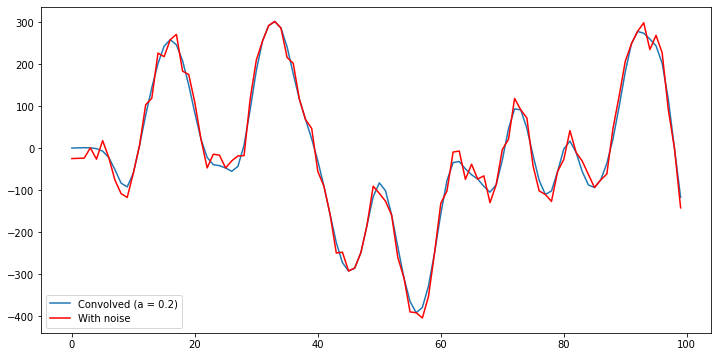

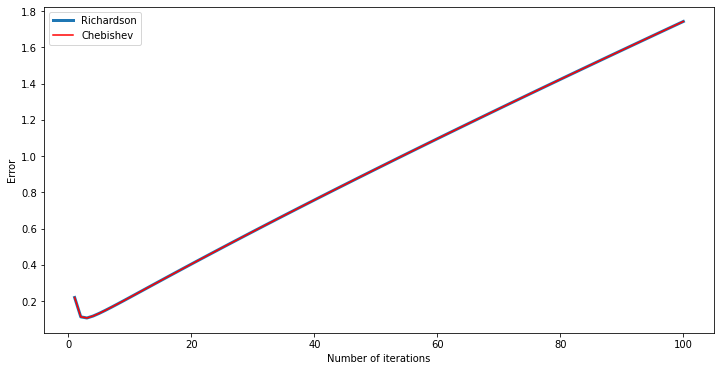

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
e = 0.001
Maxit = 100
M = 100
N = 1000

Fs, orig = read_wav('Original.wav')
orig = orig[:N]

Fs, data = read_wav('Convolved02.wav')
maxdata = max(data)
data = data[:N]

edata = np.zeros(N)
for i in range(N):
  edata[i] = data[i] + random.randint(-1, 1)*e*maxdata

plt.figure(figsize=(12, 6))
plt.plot(range(M), data[:M], label='Convolved (a = 0.2)')
plt.plot(range(M), edata[:M], 'r', label='With noise')
plt.legend()
plt.show()

T = generate_conv_matrix(N, 0.2)
res_data1, error1 = Richardson_sol(T, edata, Maxit, 1.0000003083037587, orig)
res_data2, error2 = Cheb_sol(T, edata, Maxit, orig)

plt.figure(figsize=(12, 6))
plt.plot(range(1, M+1), error1[:M], lw=3, label='Richardson')
plt.plot(range(1, M+1), error2[:M], 'r', label='Chebishev')
plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.legend()
plt.show()

Видно, что для сигнала с приличным шумом не получается быстро найти решение, так как итерационный метод не сходится. Теперь стало понятно, зачем мы вообще производили свертку. Свертка делает из звука что-то, что удобно пересчитывать и как-то еще работать с этими данными. А потом по свертке реально восстановить исходный сигнал (ну или что-то похожее на него для хорошей альфа). С сигналом с шумом такого не получится. 

То есть свертка и производит очистку сигнала от шумов.

Вид графика сильно зависит от относительной ошибки. Например, при ошибке меньше или равной 0.000001 сигнал устойчив к шумам и итерационный метод сойдется. При увеличении ошибки итерационный метод начинает сначала сходиться и потом расходиться. При дальнейшем увеличении ошибки число операций, на которых происходит расхождение уменьшается. Поэтому важно учитывать ошибку при итерационом методе.

# Problem 2

- Решите задачу 1 из прошлого задания методом сопряженных градиентов. Реализуйте вырианты для $\beta_k$ https://en.wikipedia.org/wiki/Nonlinear_conjugate_gradient_method. Сравните методы на примере графиков сходимости.

- Решите задачу 1 из прошлого задания методом сопряженных градиентов c предобуславлевателем и разными вариантами $\beta_k$. Объясните выбор предобуславлевателя.

- Попробуйте методы, которые были на семинаре, сравните сходимости.

In [14]:
import urllib.request
import os
from scipy.io import wavfile 
import pathlib
import math
import numpy as np
import scipy as sp

def downlod_wav():
  url = 'https://drive.google.com/uc?id\u003d1jybDphsdn3tma5sqmMjgFM8nrG6Om6dn\u0026export\u003ddownload'
  filename = os.path.join(pathlib.Path().absolute(), 'file.wav')
  urllib.request.urlretrieve(url, filename)

  Fs, data = wavfile.read(filename)
  return Fs, data

def read_wav(name):
  filename = os.path.join(pathlib.Path().absolute(), name)
  Fs, data = wavfile.read(filename)
  return Fs, data

def write_wav(Fs, data, name):
  filename = os.path.join(pathlib.Path().absolute(), name)
  wavfile.write(filename, Fs, data)

def generate_conv_matrix(N, alfa):
  T = []
  values = np.zeros(N)
  pi = math.pi
  s = math.sqrt(alfa/pi)
  for i in range(N):
    values[i] = s * math.exp(-alfa*(i)**2)

  tt = values.copy()
  for i in range(N):
    T.append(tt)
    if i < (N-1):
      tt = [values[i+1], *tt[:-1]]

  return np.array(T)

def mult(T, data):
  return np.dot(T, data)

N = 200    #Размер матрицы и куска сигнала для свертки

Fs, data = downlod_wav()
write_wav(Fs, data, 'Original.wav')
data = data[:N]

T = generate_conv_matrix(N, 0.2)
y = mult(T, data)
write_wav(Fs, y, 'Convolved02.wav')

T = generate_conv_matrix(N, 0.01)
y = mult(T, data)
write_wav(Fs, y, 'Convolved001.wav')

#np.seterr(all='ignore')


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def Fletcher_Reeves(r, rp, z):
  return np.dot(r, r) / np.dot(rp, rp)

def Polak_Ribiere(r, rp, z):
  return np.dot(r, (r - rp)) / np.dot(rp, rp)

def Hestenes_Stiefel(r, rp, z):
  return np.dot(r, (r - rp)) / np.dot(-z, (r - rp))

def Dai_Yuan(r, rp, z):
  return np.dot(r, r) / np.dot(-z, (r - rp))


def calc(A, b, it, f, original, x0):
  error = []
  nb = np.linalg.norm(original)
  x = x0.copy()
  r = b - np.dot(A, x)
  z = r.copy()
  for i in range(1, it):
    a = np.dot(A, z)
    aa = np.dot(r, r) / np.dot(a, z)
    x = x + np.dot(aa, z)
    rp = r.copy()
    r = r - np.dot(np.dot(aa, A),  z)
    bb = f(r, rp, z)
    z = r + np.dot(bb, z)
    nr = np.linalg.norm(x - original)
    error.append(nr / nb)
    
  return x, error

def output_graph(orig, data, res_data, l1, l2):

  M = 200     #Количество точек для отображения на графике
  
  plt.rcParams.update({'font.size': 18})
  plt.figure(figsize=(15, 5))
  plt.plot(range(M), orig[:M], 'k', label='Original')
  plt.plot(range(M), data[:M], 'r', label=l1)
  plt.plot(range(M), res_data[:M], label=l2)
  plt.legend()
  plt.show()

def output_graph_errors(err1, err2, err3, err4, points, t):
  xx = range(len(err1))
  plt.rcParams.update({'font.size': 18})
  plt.figure(figsize=(15, 5))
  if points == -1:
    first = 0
  else:
    first = len(err1) - points
  xx = xx[first:]
  plt.plot(xx, err1[first:], label='Fletcher–Reeves')
  plt.plot(xx, err2[first:], label='Polak–Ribière')
  plt.plot(xx, err3[first:], label='Hestenes-Stiefel')
  plt.plot(xx, err4[first:], label='Dai–Yuan')
  plt.title(t)
  plt.xlabel('Number of iterations')
  plt.ylabel('Error')
  plt.legend()
  plt.show()

Решим методом сопряженных градиентов

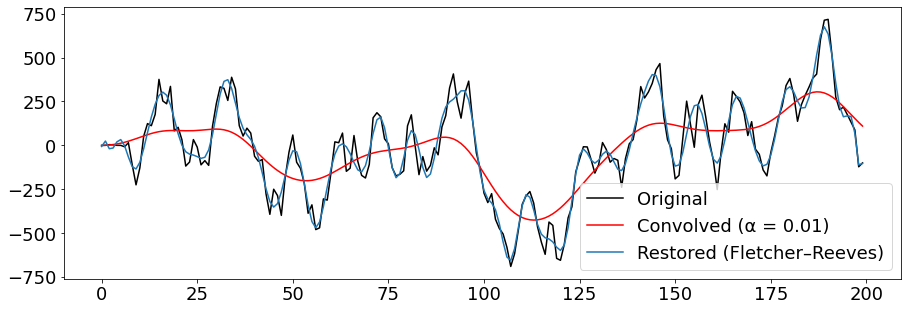

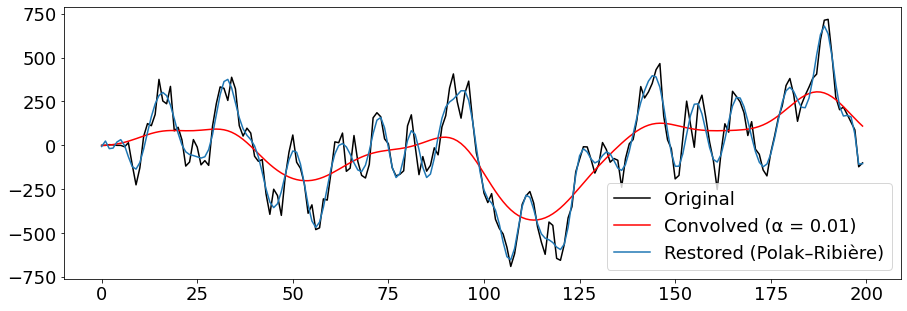

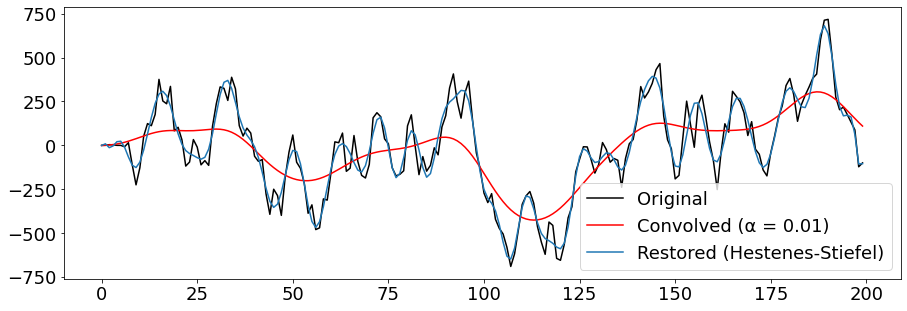

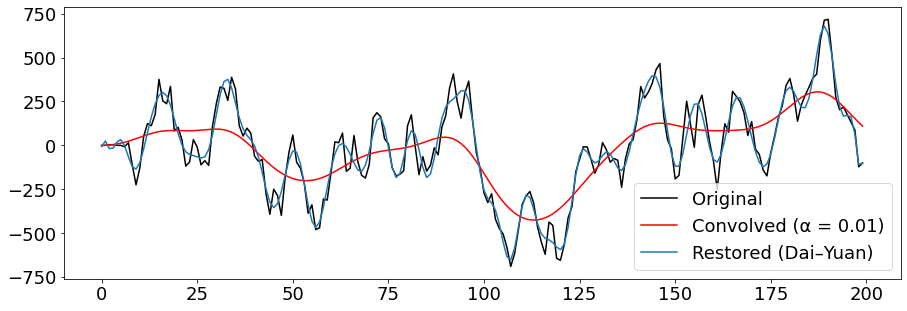

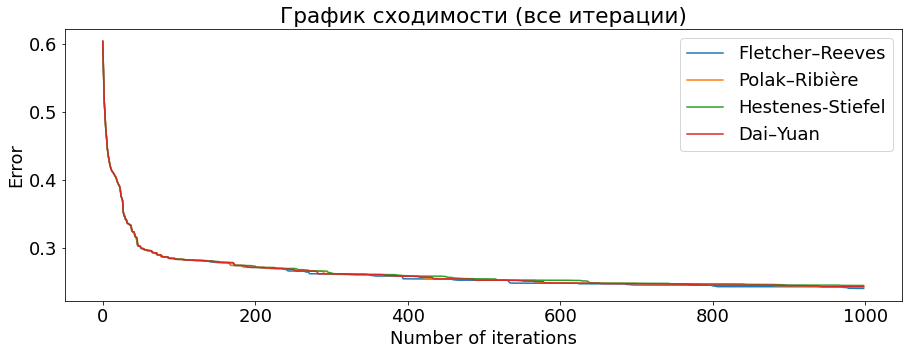

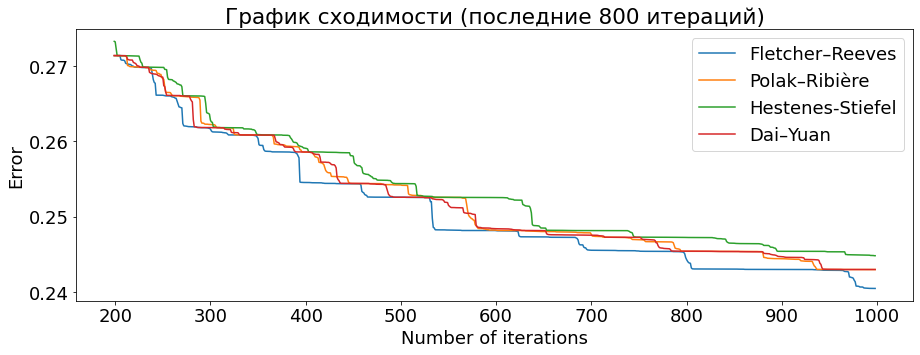

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random

Maxit = 1000 #Максимальное количество итераций
Fs, orig = read_wav('Original.wav')
Fs, data = read_wav('Convolved001.wav')
N = len(data)
orig = orig[:N]
T = generate_conv_matrix(N, 0.01)
data = data[:N]
# начальное приближение
x0 = np.zeros(N)

res_data, err1 = calc(T, data, Maxit, Fletcher_Reeves, orig, x0)
output_graph(orig, data, res_data, 'Convolved (α = 0.01)', 'Restored (Fletcher–Reeves)')
res_data, err2 = calc(T, data, Maxit, Polak_Ribiere, orig, x0)
output_graph(orig, data, res_data, 'Convolved (α = 0.01)', 'Restored (Polak–Ribière)')
res_data, err3 = calc(T, data, Maxit, Hestenes_Stiefel, orig, x0)
output_graph(orig, data, res_data, 'Convolved (α = 0.01)', 'Restored (Hestenes-Stiefel)')
res_data, err4 = calc(T, data, Maxit, Dai_Yuan, orig, x0)
output_graph(orig, data, res_data, 'Convolved (α = 0.01)', 'Restored (Dai–Yuan)')

output_graph_errors(err1, err2, err3, err4, -1, 'График сходимости (все итерации)')
output_graph_errors(err1, err2, err3, err4, 800, 'График сходимости (последние 800 итераций)')



Видно, что на более раннем числе итераций начинает уменьшать ошибку Fletcher–Reeves, потом Dai–Yuan, после Polak–Ribière, а затем Hestenes-Stiefel. То есть если число итераций мало, лучше использовать Fletcher–Reeves, на большом же числе итераций они практически эквивалентны.


Решим методом сопряженных градиентов c предобуславлевателем. Делаем это, потому что сходимость довольно медленная, потому что $cond(A)$ подрядка $10^{19}$, а это очень плохо для сходимости. Выбираем $E$ из условия, чтобы матрица была близка к $A$, $cond(M^{-1}A)$ был поменьше, чем $cond(A)$. 

Сначала возьмем за $E$ - нижнюю треугольную часть матрицы $A$. 

Потом берем за $E$ нижнедиагональную, где в $E$ на диагонали элементы с диагонали $A$, умноженные на большое число, а под ней единички.

Потом берем за $E$ диагональ $A$.

In [17]:
def predob_L(A):
  E = A.copy()
  n = len(A)
  for i in range(n):
    for j in range(i+1, n):
      E[i][j] = 0
  return E

In [18]:
def predob_LD(A):
  n = len(A)
  E = np.zeros((n, n))
  for i in range(n):
    E[i][i] = 100000*A[i][i]
    for j in range(i):
      E[i][j] = 1
  return E

In [19]:
def predob_D(A):
  n = len(A)
  E = np.zeros((n, n))
  for i in range(n):
    E[i][i] = A[i][i]
  return E

In [20]:
def output_graph_errors_predob(err1, err2, points, t):
  xx = range(len(err1))
  plt.rcParams.update({'font.size': 18})
  plt.figure(figsize=(15, 5))
  if points == -1:
    first = 0
  else:
    first = len(err1) - points
  xx = xx[first:]
  plt.plot(xx, err1[first:], label='Fletcher–Reeves')
  plt.plot(xx, err2[first:], label='Polak–Ribière')
  plt.title(t)
  plt.xlabel('Number of iterations')
  plt.ylabel('Error')
  plt.legend()
  plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
import scipy.sparse.linalg as spla

def calc_predob(A, b, it, f, p, original, x0):
  n = len(b)
  E = p(A)
  E_tr = np.transpose(E)
  M = np.dot(E, E_tr)
  M_inv = np.linalg.inv(M)
  print('Число обусловленности матрицы M_inv*A =', np.linalg.cond(np.dot(M_inv, A)))
  error = []
  nb = np.linalg.norm(original)

  x = x0.copy()
  r = b - np.dot(A, x)
  z = np.dot(M_inv, r)
  p = z.copy()
  for i in range(0, it):
    aa = np.dot(r, z) / np.dot(p, np.dot(A, p))  
    x = x + aa * p
    rp = r.copy()
    r = r - aa * np.dot(A, p)
    zp = z.copy()
    z = np.dot(M_inv, r)
    bb = f(r, rp, z, zp)
    p = z + bb * p

    nr = np.linalg.norm(x - original)
    error.append(nr / nb)
  
  #x = np.dot(E_tr, x)
    
  return x, error
    
def Fletcher_Reeves_predob(r, rp, z, zp):
  return np.dot(r, z) / np.dot(rp, zp)

def Polak_Ribiere_predob(r, rp, z, zp):
  return np.dot(r, (z - zp)) / np.dot(rp, zp)

Число обусловленности матрицы M_inv*A = 3.26379762381092e+18


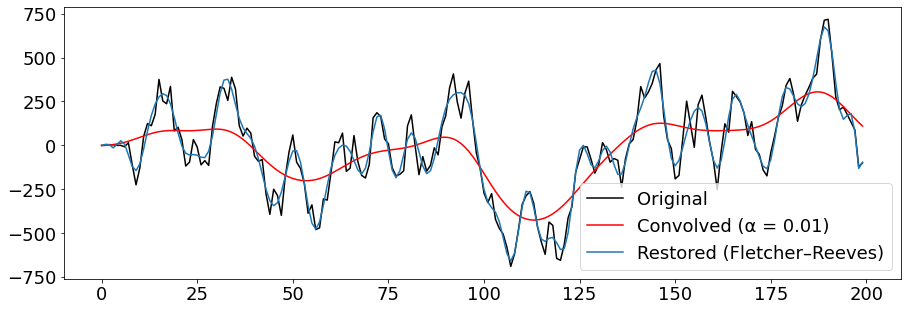

Число обусловленности матрицы M_inv*A = 3.26379762381092e+18


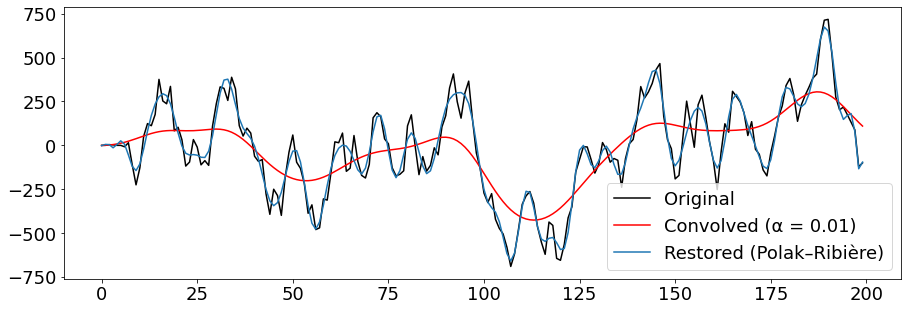

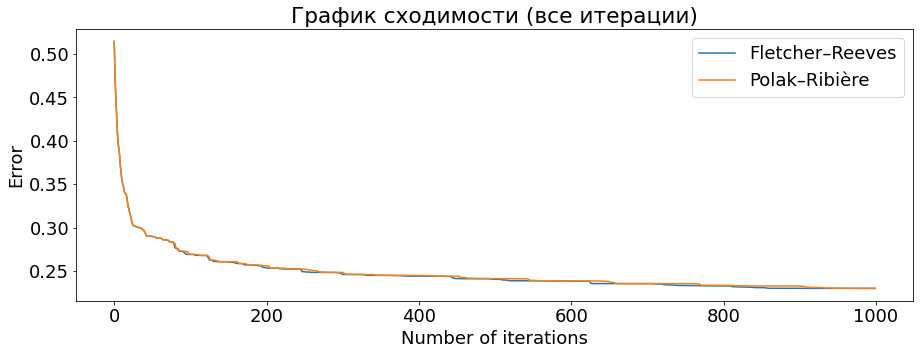

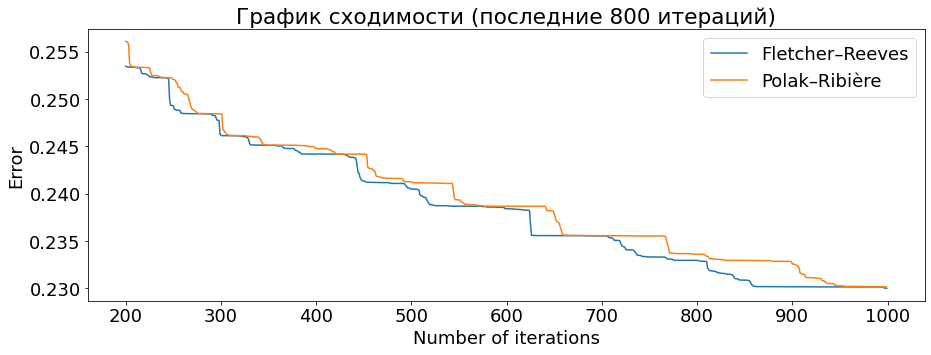

Число обусловленности матрицы M_inv*A = 3.7534141727654856e+18


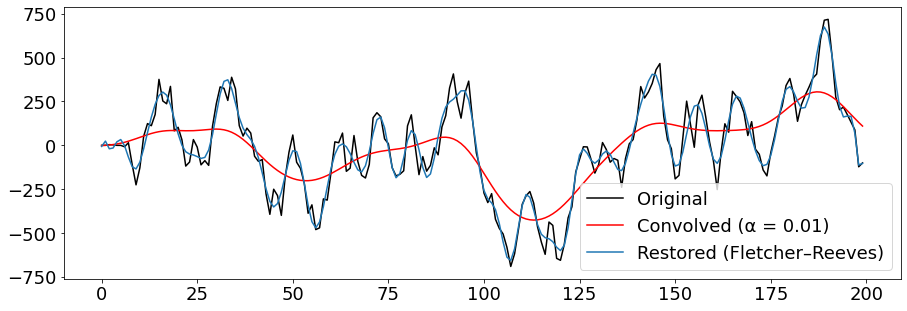

Число обусловленности матрицы M_inv*A = 3.7534141727654856e+18


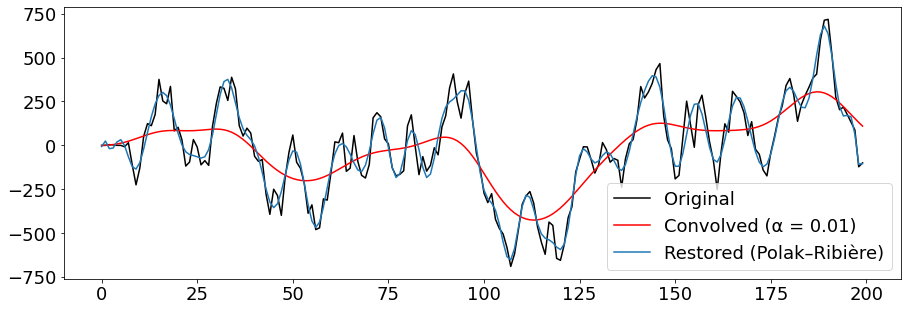

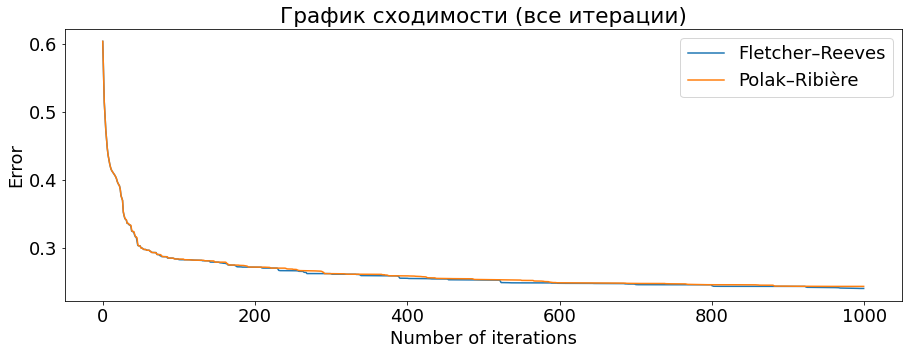

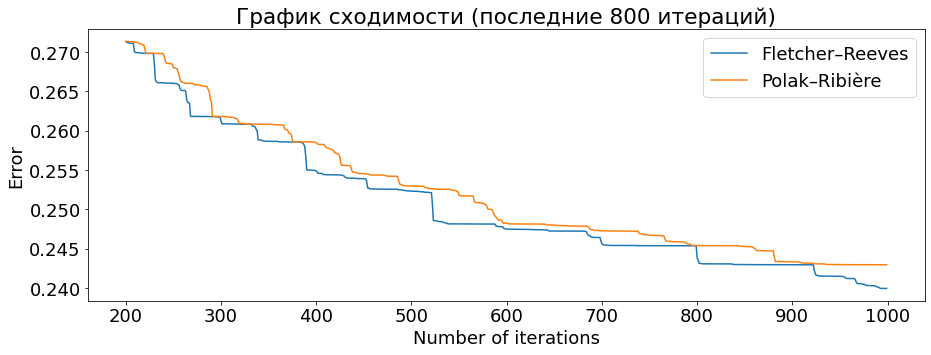

Число обусловленности матрицы M_inv*A = 5.055205795945264e+18


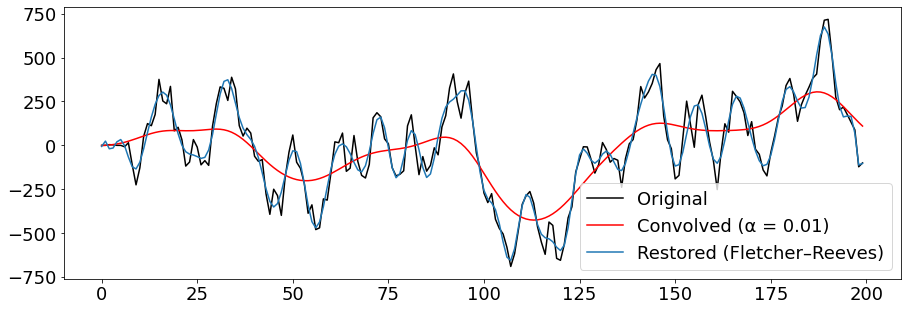

Число обусловленности матрицы M_inv*A = 5.055205795945264e+18


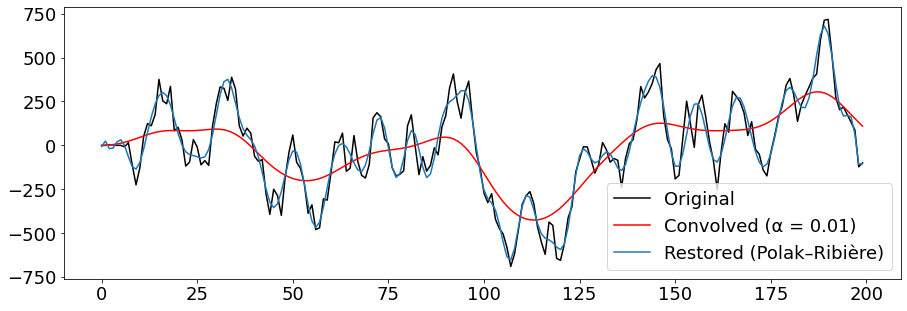

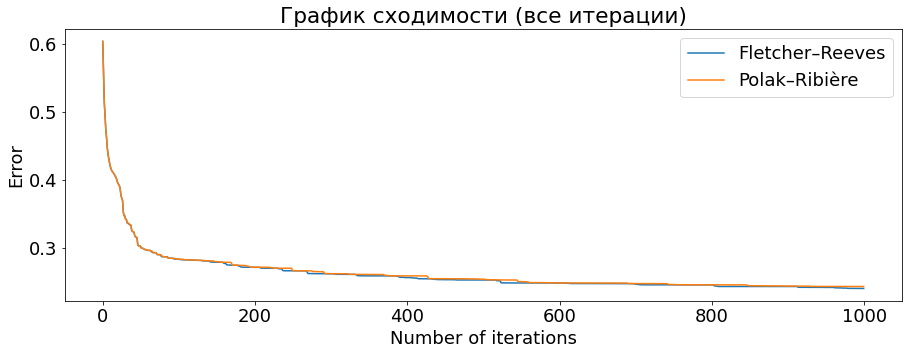

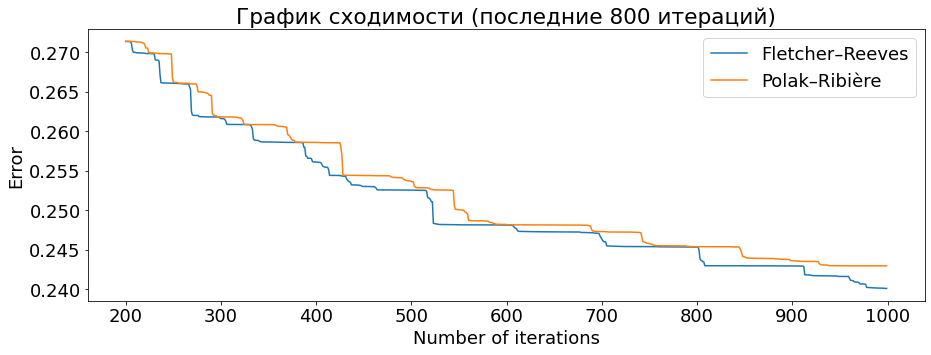

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import random

Maxit = 1000 #Максимальное количество итераций
Fs, orig = read_wav('Original.wav')
Fs, data = read_wav('Convolved001.wav')
N = len(data)
orig = orig[:N]
T = generate_conv_matrix(N, 0.01)
data = data[:N]
# начальное приближение
x0 = np.zeros(N)

res_data, err1 = calc_predob(T, data, Maxit, Fletcher_Reeves_predob, predob_L, orig, x0)
output_graph(orig, data, res_data, 'Convolved (α = 0.01)', 'Restored (Fletcher–Reeves)')
res_data, err2 = calc_predob(T, data, Maxit, Polak_Ribiere_predob, predob_L, orig, x0)
output_graph(orig, data, res_data, 'Convolved (α = 0.01)', 'Restored (Polak–Ribière)')

output_graph_errors_predob(err1, err2, -1, 'График сходимости (все итерации)')
output_graph_errors_predob(err1, err2, 800, 'График сходимости (последние 800 итераций)')

res_data, err1 = calc_predob(T, data, Maxit, Fletcher_Reeves_predob, predob_LD, orig, x0)
output_graph(orig, data, res_data, 'Convolved (α = 0.01)', 'Restored (Fletcher–Reeves)')
res_data, err2 = calc_predob(T, data, Maxit, Polak_Ribiere_predob, predob_LD, orig, x0)
output_graph(orig, data, res_data, 'Convolved (α = 0.01)', 'Restored (Polak–Ribière)')

output_graph_errors_predob(err1, err2, -1, 'График сходимости (все итерации)')
output_graph_errors_predob(err1, err2, 800, 'График сходимости (последние 800 итераций)')

res_data, err1 = calc_predob(T, data, Maxit, Fletcher_Reeves_predob, predob_D, orig, x0)
output_graph(orig, data, res_data, 'Convolved (α = 0.01)', 'Restored (Fletcher–Reeves)')
res_data, err2 = calc_predob(T, data, Maxit, Polak_Ribiere_predob, predob_D, orig, x0)
output_graph(orig, data, res_data, 'Convolved (α = 0.01)', 'Restored (Polak–Ribière)')

output_graph_errors_predob(err1, err2, -1, 'График сходимости (все итерации)')
output_graph_errors_predob(err1, err2, 800, 'График сходимости (последние 800 итераций)')


Хоть мы и уменьшили число обусловленности на порядок, сходимость почти такая же.

Похоже это связано с тем, что матрица у нас плотная, числа в ней в основном очень маленькие. Видимо при проведении операций с обуславливателями, при умножении в итерационном методе на эту матрицу $A$ накапливаются ошибки, деления на маленькое число и прочее. Поэтому сходимость не очень хорошая.

Сравним методы из семинара.

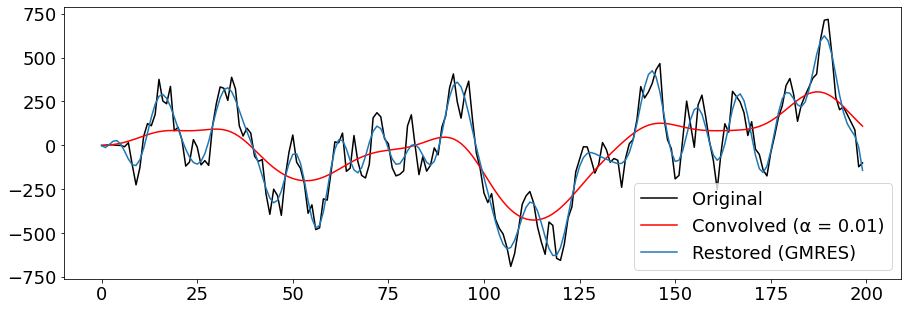

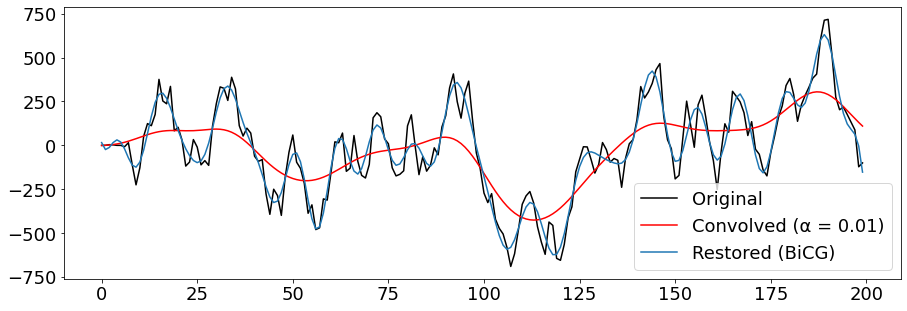

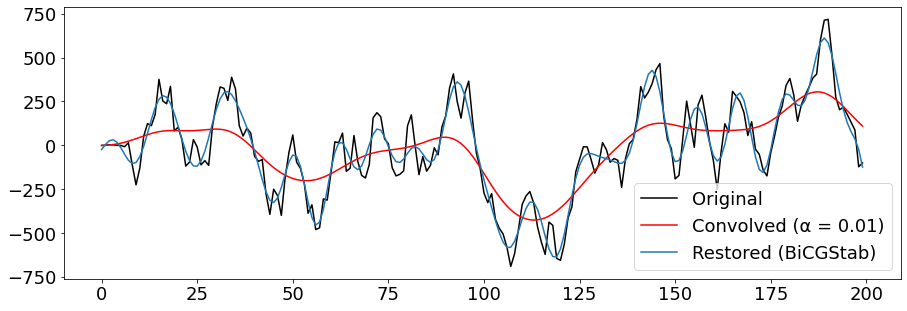

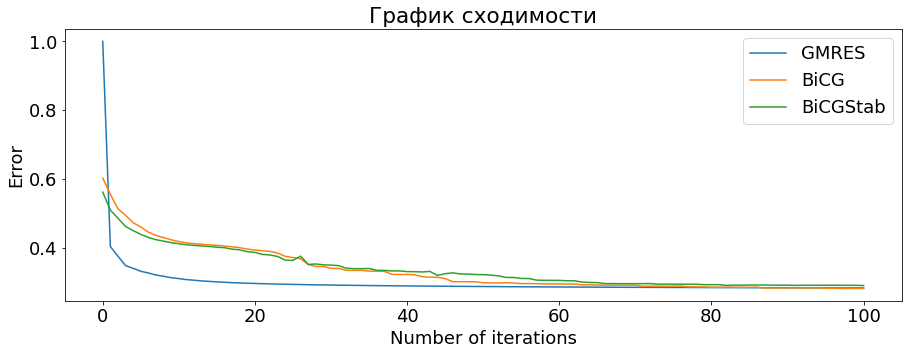

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.sparse.linalg as ln

Maxit = 1000 #Максимальное количество итераций
Fs, orig = read_wav('Original.wav')
Fs, data = read_wav('Convolved001.wav')
N = len(data)
orig = orig[:N]
T = generate_conv_matrix(N, 0.01)
data = data[:N]

nb = np.linalg.norm(orig)
error1 = []
error2 = []
error3 = []

def callback_gmres(x):
  error1.append(np.linalg.norm(x-orig) / nb)

def callback_bicg(x):
  error2.append(np.linalg.norm(x-orig) / nb)

def callback_bicgstab(x):
  error3.append(np.linalg.norm(x-orig) / nb)

res_data = ln.gmres(T, data, callback=callback_gmres, maxiter=100, tol=1e-16, callback_type='x')
output_graph(orig, data, res_data[0], 'Convolved (α = 0.01)', 'Restored (GMRES)')
res_data = ln.bicg(T, data, callback=callback_bicg, maxiter=101, tol=1e-16)
output_graph(orig, data, res_data[0], 'Convolved (α = 0.01)', 'Restored (BiCG)')
res_data = ln.bicgstab(T, data, callback=callback_bicgstab, maxiter=101, tol=1e-16)
output_graph(orig, data, res_data[0], 'Convolved (α = 0.01)', 'Restored (BiCGStab)')

xx = range(len(error1))
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(15, 5))
first = 0
xx = xx[first:]
plt.plot(xx, error1[first:], label='GMRES')
plt.plot(xx, error2[first:], label='BiCG')
plt.plot(xx, error3[first:], label='BiCGStab')

plt.title('График сходимости')
plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.legend()
plt.show()


Видно, что быстрее всего сходится $GMRES$. $BiCG$ и $BiCGStab$ ведут себя примерно одинаково на большом числе итераций.